In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [3]:
import sys
sys.path.insert(0, '../')

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F


In [7]:
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.current_device())
print(torch.cuda.get_device_name(0))

True
1
0
NVIDIA GeForce RTX 3070 Laptop GPU


In [8]:
from tools.ramanflow.read_data import ReadData as rd
from tools.ramanflow.prep_data import PrepData as rpd

In [9]:
f_sup, _ = rd.read_data("../data/20220422 SERS data generation/analyte 1/mapping50X50/1_3min_b3_50X50_spectral_mapping_1.tif")

In [10]:
spectra_dataset = rd.read_data("dataset.npy")

In [11]:
spectra_dataset_baselined = rd.read_data("spectra_dataset_baselined.npy")

In [11]:
# Print the shape of the dataset
print(spectra_dataset.shape)

(73312, 1600)


In [14]:
label_mask = np.zeros((73312))

label_mask[0:7500] = 1
label_mask[7500:15000] = 2
label_mask[15000:22500] = 3
label_mask[22500:30000] = 4
label_mask[30000:37500] = 5
label_mask[37500:44668] = 6
label_mask[44668:47740] = 7
label_mask[47740:] = 8

In [ ]:
label_mask[0:7500] = [1, 0, 0, 0]
label_mask[7500:15000] = [0, 1, 0, 0]
label_mask[15000:22500] = [0, 0, 1, 0]
label_mask[22500:30000] = [1, 1, 0, 0]
label_mask[30000:37500] = [1, 0, 1, 0]
label_mask[37500:44668] = [0, 1, 1, 0]
label_mask[44668:47740] = [1, 1, 1, 0]
label_mask[47740:] = [0, 0, 0, 1]

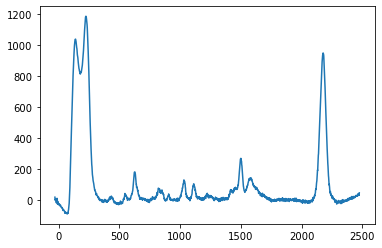

In [13]:
# Plot the mean of the dataset that are 1 in the label mask
plt.plot(f_sup, np.mean(spectra_dataset_baselined[label_mask == 3], axis=0))

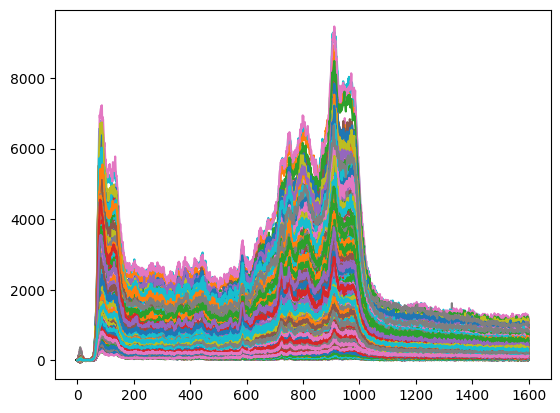

In [9]:
# Plot all the spectra that are 1 in the label mask
plt.plot(spectra_dataset[label_mask == 1].T);

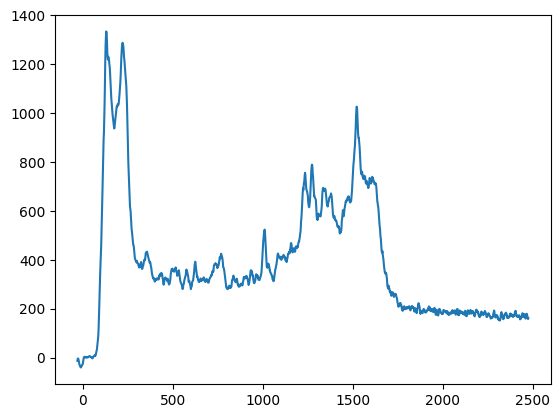

In [10]:
# plt.plot(f_sup, spectra_dataset_sg[label_mask == 1].T);
plt.plot(f_sup, spectra_dataset_sg[0]);

In [11]:
# Baseline stimation with asymmetric least squares
# According to paper: "Baseline Correction with Asymmetric Least Squares Smoothing" 
# by Paul H. C. Eilers and Hans F.M. Boelens. October 21, 2005

# We need the following packages here:
from scipy import sparse
from scipy.sparse.linalg import spsolve

# Baseline stimation function:
def baseline_als(y, lam, p, niter=100):
    L = len(y)
    D = sparse.diags([1,-2,1],[0,-1,-2], shape=(L,L-2))
    w = np.ones(L)
    for i in range(niter):
        W = sparse.spdiags(w, 0, L, L)
        Z = W + lam * D.dot(D.transpose())
        z = spsolve(Z, w*y)
        w = p * (y > z) + (1-p) * (y < z)
    return z

In [20]:
def baseline_als(y, lam, p, niter=10):
  L = len(y)
  D = sparse.csc_matrix(np.diff(np.eye(L), 2))
  w = np.ones(L)
  for i in range(niter):
    W = sparse.spdiags(w, 0, L, L)
    Z = W + lam * D.dot(D.transpose())
    z = spsolve(Z, w*y)
    w = p * (y > z) + (1-p) * (y < z)
  return z

In [17]:
sparse.diags([1,-2,1],[0,-1,-2], shape=(1600,1600-2))

<1600x1598 sparse matrix of type '<class 'numpy.float64'>'
	with 4794 stored elements (3 diagonals) in DIAgonal format>

In [12]:
# Parameters for this case:
l = 10000000 # smoothness
p = 0.05 # asymmetry

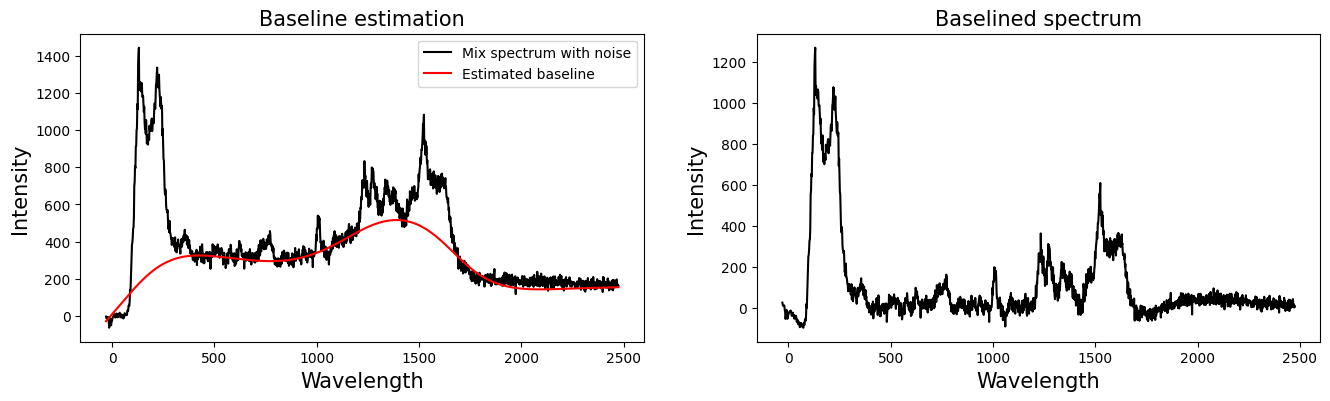

In [21]:
# Estimation of the baseline:
estimated_baselined = baseline_als(spectra_dataset[0], l, p)

# Baseline subtraction:
baselined_spectrum = spectra_dataset[0] - estimated_baselined

# How does it look like?
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,4))

# We compared the original mix spectrum and the estimated baseline:
ax1.plot(f_sup, spectra_dataset[0], color = 'black', label = 'Mix spectrum with noise' )
ax1.plot(f_sup, estimated_baselined, color = 'red', label = 'Estimated baseline')
ax1.set_title('Baseline estimation', fontsize = 15)
ax1.set_xlabel('Wavelength', fontsize = 15)
ax1.set_ylabel('Intensity',  fontsize = 15)
ax1.legend()

# We plot the mix spectrum after baseline subtraction
ax2.plot(f_sup, baselined_spectrum, color = 'black', label = 'Baselined spectrum with noise' )
ax2.set_title('Baselined spectrum', fontsize = 15)
ax2.set_xlabel('Wavelength', fontsize = 15)
ax2.set_ylabel('Intensity',  fontsize = 15)
plt.show()

In [14]:
estimated_baselined.shape

(1600,)

In [22]:
# Estimate the baseline for all the spectra in the dataset using the function baseline_als
# Create a separate variable called spectra_dataset_baselined

spectra_dataset_baselined = np.zeros((73312, 1600))

In [26]:
from joblib import Parallel, delayed
import multiprocessing

def compute_baseline(idx):
    if idx % 100 == 0:
        print("Processing spectrum", idx)
    return baseline_als(spectra_dataset[idx], l, p)

num_cores = multiprocessing.cpu_count()
spectra_dataset_baselined = Parallel(n_jobs=num_cores)(delayed(compute_baseline)(idx) for idx in range(len(spectra_dataset)))
spectra_dataset_baselined = spectra_dataset - np.array(spectra_dataset_baselined)

Processing spectrum 0
Processing spectrum 100
Processing spectrum 200
Processing spectrum 300
Processing spectrum 400
Processing spectrum 500
Processing spectrum 600
Processing spectrum 700
Processing spectrum 800
Processing spectrum 900
Processing spectrum 1000
Processing spectrum 1100
Processing spectrum 1200
Processing spectrum 1300
Processing spectrum 1400
Processing spectrum 1500
Processing spectrum 1600
Processing spectrum 1700
Processing spectrum 1800
Processing spectrum 1900
Processing spectrum 2000
Processing spectrum 2100
Processing spectrum 2200
Processing spectrum 2300
Processing spectrum 2400
Processing spectrum 2500
Processing spectrum 2600
Processing spectrum 2700
Processing spectrum 2800
Processing spectrum 2900
Processing spectrum 3000
Processing spectrum 3100
Processing spectrum 3200
Processing spectrum 3300
Processing spectrum 3400
Processing spectrum 3500
Processing spectrum 3600
Processing spectrum 3700
Processing spectrum 3800
Processing spectrum 3900
Processing s

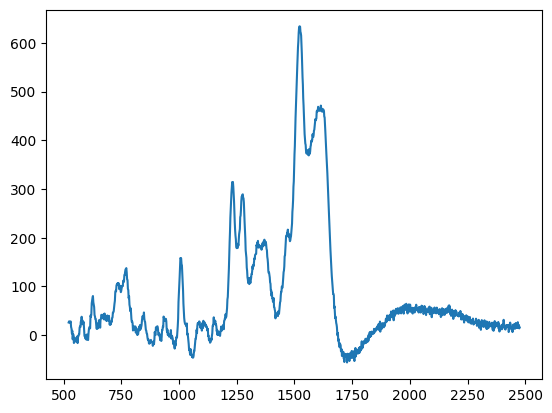

In [35]:
# Plot the mean of the dataset that are 1 in the label mask from idx 300 till end
plt.plot(f_sup[300:], np.mean(spectra_dataset_baselined[0:7500, 300:], axis=0))

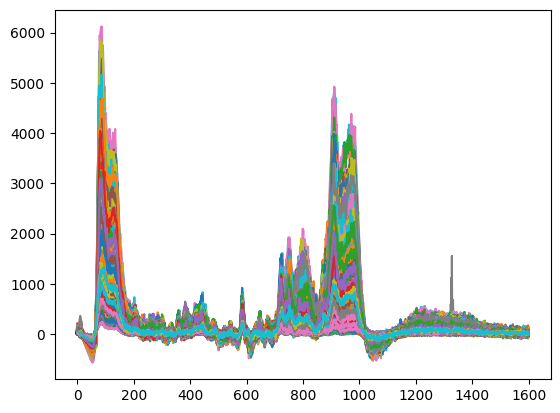

In [29]:
# Plot all the spectra that are 1 in the label mask from index 200 till end
plt.plot(spectra_dataset_baselined[label_mask == 1][200:].T);

In [10]:
scaler = StandardScaler()

In [18]:
min_max_scaler = MinMaxScaler()

In [12]:
scaled_dataset = np.zeros_like(spectra_dataset)

In [21]:
# Fit the scaler to the dataset and transform the dataset where the label mask is 1
scaled_dataset[label_mask == 1] = scaler.fit_transform(spectra_dataset[label_mask == 1])

In [23]:
# Fit the min_max_scaler to the dataset and transform the dataset where the label mask is 1
scaled_dataset[label_mask == 1] = min_max_scaler.fit_transform(spectra_dataset[label_mask == 1])

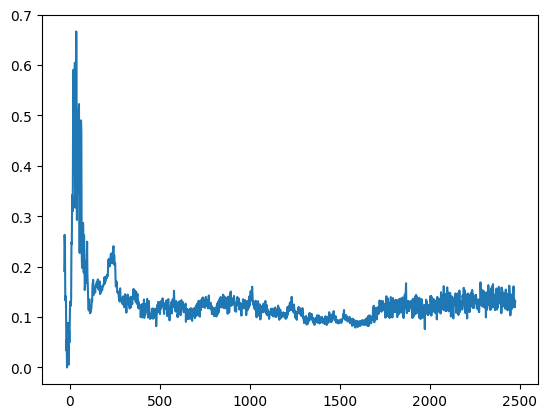

In [24]:
plt.plot(f_sup, scaled_dataset[0])

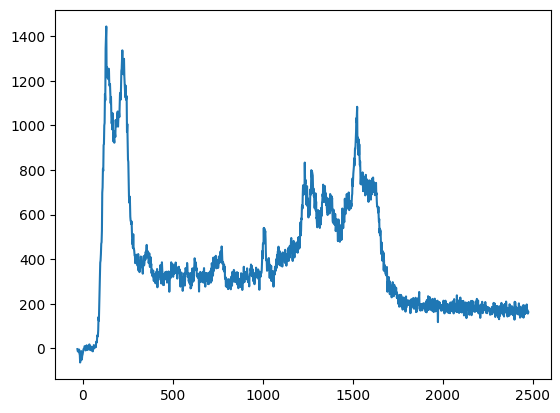

In [25]:
plt.plot(f_sup, spectra_dataset[0])

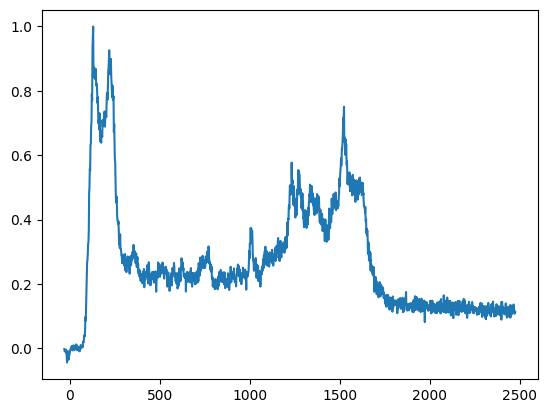

In [27]:
plt.plot(f_sup, normalized_spectra[0])

In [12]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

## Normalize spectra

In [15]:
max_values = np.max(spectra_dataset, axis=1)  # Get the maximum value for each spectrum
normalized_spectra = spectra_dataset / max_values[:, np.newaxis]  # Divide each spectrum by its maximum value

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


In [16]:
normalized_spectra_wo_nan = normalized_spectra[~np.isnan(normalized_spectra).any(axis=1)]

# Remove the values with the same index from the label mask
label_mask_wo_nan = label_mask[~np.isnan(normalized_spectra).any(axis=1)]

In [17]:
normalized_spectra_wo_nan.shape

(72782, 1600)

## PCA

In [16]:
from sklearn.decomposition import PCA

In [17]:
n_components= 7
model = PCA(n_components)
W_PCA = model.fit_transform(normalized_spectra_wo_nan)
H_PCA = model.components_
t_dataN_PCA = H_PCA
f_dataN_PCA = W_PCA

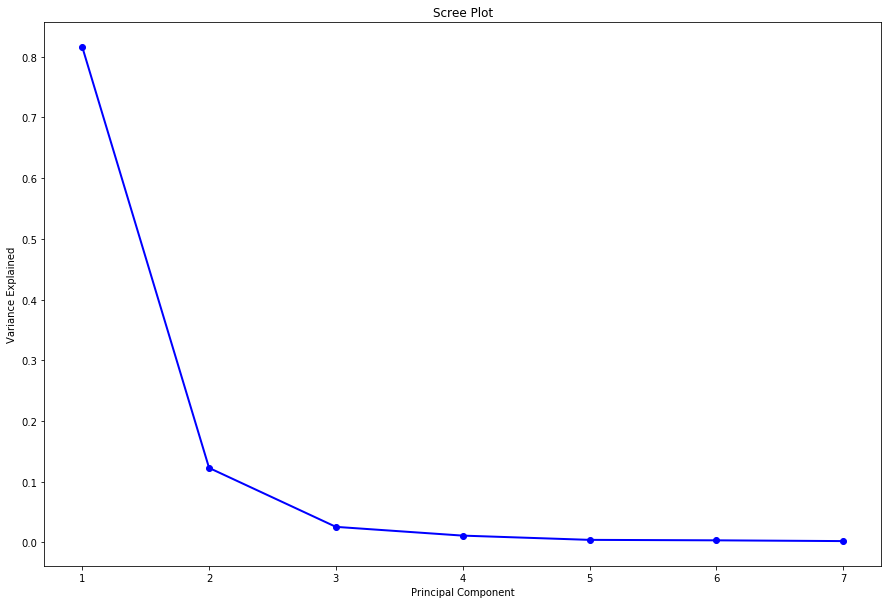

In [18]:
PC_values = np.arange(model.n_components_) + 1
plt.figure(figsize=(15,10))
plt.plot(PC_values, model.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

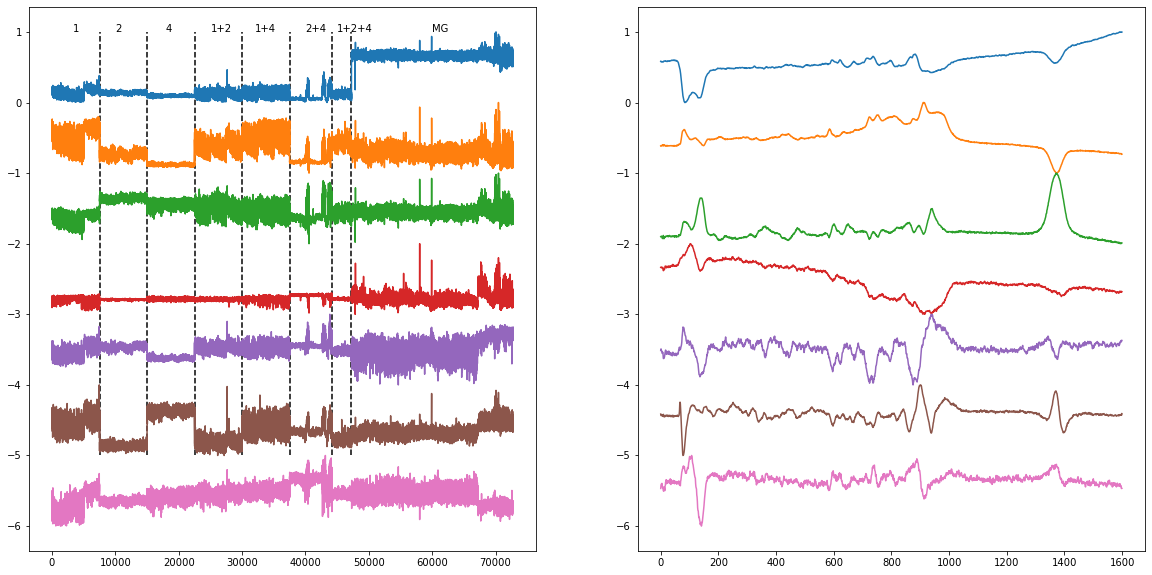

In [21]:
# Plot the first subplot
plt.figure(figsize = (20, 10))
plt.subplot(121)
for i in range(n_components):
    # Normalize and plot each column of f_dataN_PCA
    plt.plot((f_dataN_PCA[:,i]-min(f_dataN_PCA[:,i]))/np.mean(max(f_dataN_PCA[:,i])-min(f_dataN_PCA[:,i]))-i)
    
# Add vertical lines and text labels
plt.vlines(x=[7500, 15000, 22500, 30000, 37500, 44188, 47260], ymin=-5, ymax=1, colors="k", linestyles="dashed")
plt.text(3250,1,"1")
plt.text(10000,1,"2")
plt.text(18000,1,"4")
plt.text(25000,1,"1+2")
plt.text(32000,1,"1+4")
plt.text(40000,1,"2+4")
plt.text(45000,1,"1+2+4")
plt.text(60000,1,"MG")

# Plot the second subplot
plt.subplot(122)
for i in range(n_components):
    # Normalize and plot each row of t_dataN_PCA
    plt.plot(((t_dataN_PCA[i]-min(t_dataN_PCA[i]))/(max(t_dataN_PCA[i])-min(t_dataN_PCA[i]))-i))

plt.show()

## KNN

In [19]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

In [23]:
# Assuming your dataset is stored in a numpy array called 'data' and the corresponding labels are stored in 'labels'
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(normalized_spectra_wo_nan, label_mask_wo_nan, test_size=0.2, random_state=42)

# Perform PCA on the training set
pca = PCA()
pca.fit(X_train)
X_train_pca = pca.transform(X_train)

# Fit a KNN classifier on the transformed training set
knn = KNeighborsClassifier(n_neighbors=4)
knn.fit(X_train_pca, y_train)

# Transform the testing set using the same PCA object
X_test_pca = pca.transform(X_test)

# Predict the labels of the testing set using the trained KNN classifier
y_pred = knn.predict(X_test_pca)

# Evaluate the performance of the classifier
accuracy = np.mean(y_pred == y_test)
print(f'Test Accuracy: {accuracy}')

Test Accuracy: 0.9986947860136017


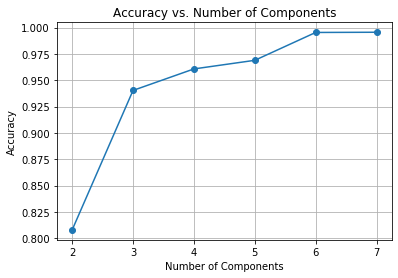

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier

# Assuming your dataset is stored in a numpy array called 'data' and the corresponding labels are stored in 'labels'

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(normalized_spectra_wo_nan, label_mask_wo_nan, test_size=0.2, random_state=42)

# Define the range of components to test
components_range = range(2, 8)

# Initialize a list to store the accuracy results
accuracy_results = []

for n_components in components_range:
    # Perform PCA on the training set with the current number of components
    pca = PCA(n_components=n_components)
    pca.fit(X_train)
    X_train_pca = pca.transform(X_train)

    # Fit a KNN classifier on the transformed training set
    knn = KNeighborsClassifier(n_neighbors=n_components)
    knn.fit(X_train_pca, y_train)

    # Transform the testing set using the same PCA object
    X_test_pca = pca.transform(X_test)

    # Predict the labels of the testing set using the trained KNN classifier
    y_pred = knn.predict(X_test_pca)

    # Calculate and store the accuracy for this number of components
    accuracy = np.mean(y_pred == y_test)
    accuracy_results.append(accuracy)

# Plot the accuracy results
plt.plot(components_range, accuracy_results, marker='o')
plt.title('Accuracy vs. Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('Accuracy')
plt.xticks(components_range)
plt.grid(True)
plt.show()

In [45]:
y_pred.shape

(14557,)

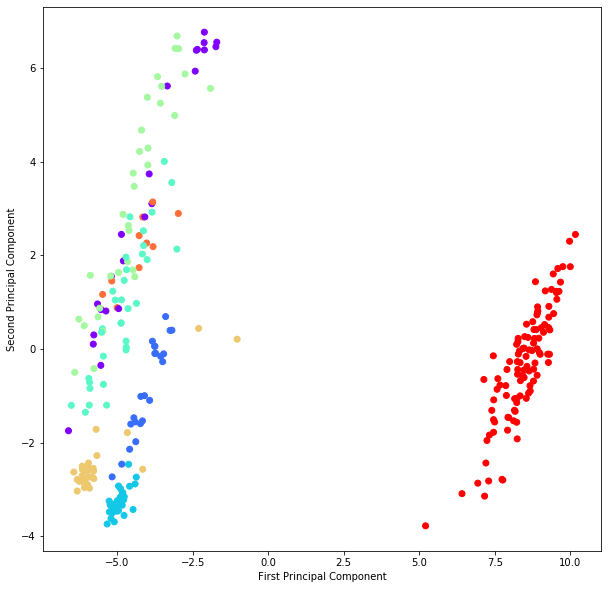

In [24]:
# Create a scatter plot with every 200th point
plt.figure(figsize=(10, 10))
plt.scatter(X_train_pca[::200, 0], X_train_pca[::200, 1], c=y_train[::200], cmap='rainbow')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.show()

In [25]:
def scatter_plot_with_subset(X, y, num_points):
    # Create a figure with subplots
    fig, axes = plt.subplots(2, 3, figsize=(20, 20))
    plt.subplots_adjust(wspace=0.4, hspace=0.4)
    
    # Define the combinations of principal components
    combinations = [(0, 1), (0, 2), (1, 2), (0, 3), (1, 3), (2, 3)]
    
    labels = ["Car", "Thia", "Aceta", "Car+Thia", "Car+Aceta", "Thia+Aceta", "Car+Thia+Aceta", "MG"]
    
    for i, (pc1, pc2) in enumerate(combinations):
        row, col = i // 3, i % 3
        ax = axes[row, col]
        
        # Scatter plot with every num_points
        sc = ax.scatter(X[::num_points, pc1], X[::num_points, pc2], c=y[::num_points], cmap='rainbow')
        ax.set_xlabel(f'Principal Component {pc1 + 1}')
        ax.set_ylabel(f'Principal Component {pc2 + 1}')
        
        # Add a legend with labels
        handles, _ = sc.legend_elements(num=len(labels))
        ax.legend(handles, labels, title="Classes")
    
    plt.show()

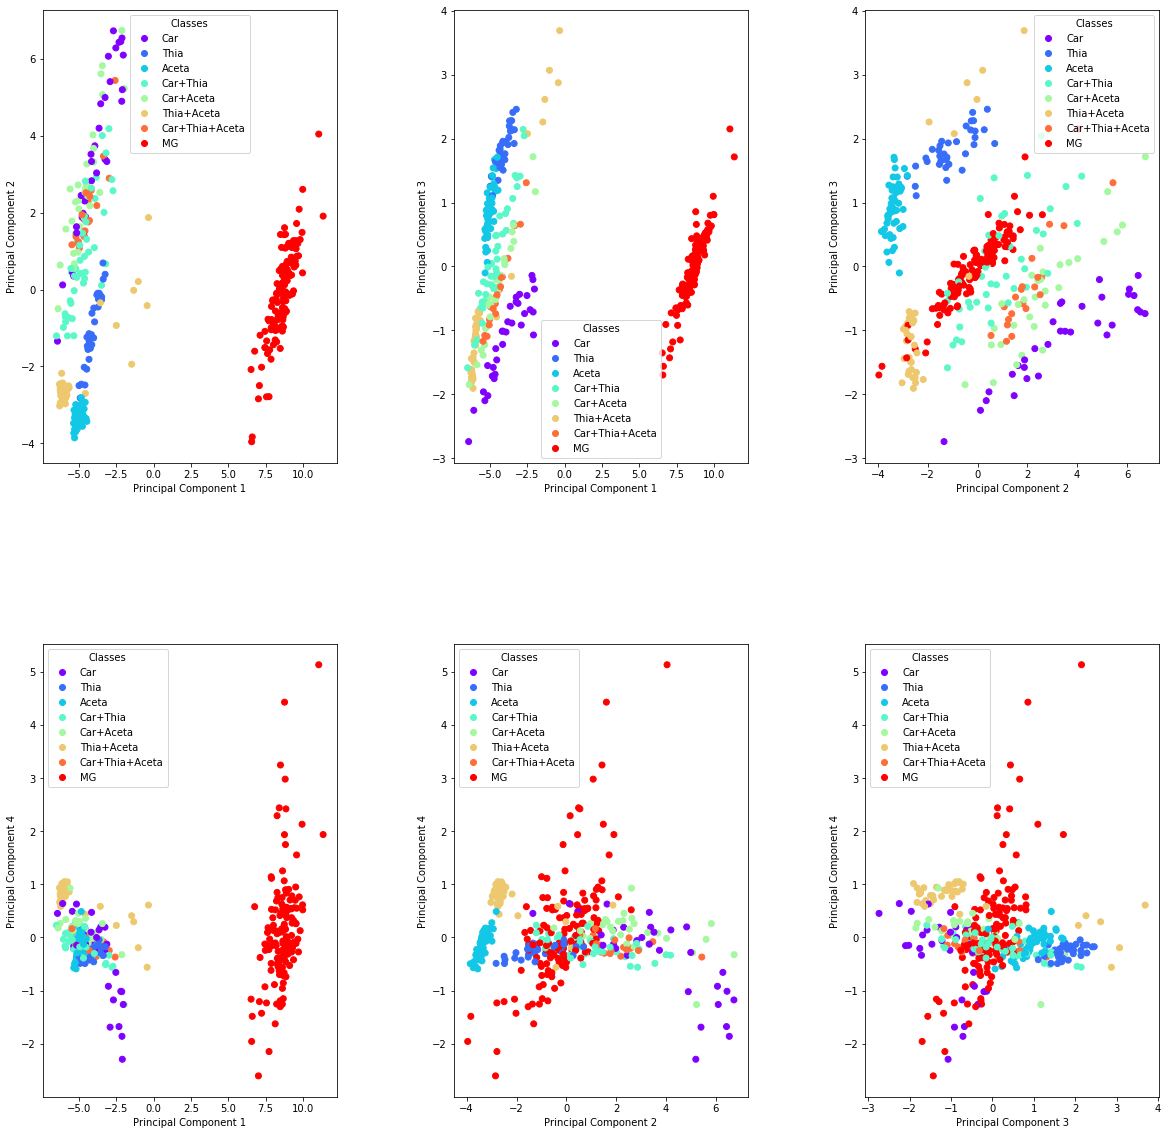

In [26]:
# Call the function with the desired number of points
scatter_plot_with_subset(X_train_pca, y_train, num_points=150)

## SVM

In [27]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Step 1: Data Preprocessing - Import data and labels

# Step 2: Data Splitting
X_train, X_test, y_train, y_test = train_test_split(normalized_spectra_wo_nan, label_mask_wo_nan, test_size=0.2, random_state=42)

# Step 3: Feature Selection or Dimensionality Reduction (if needed)

# Step 4: Model Selection - Choose the SVM model
svm_model = SVC(kernel='rbf', C=1.0, gamma='scale')  # Example with an RBF kernel

# Step 5: Model Training
svm_model.fit(X_train, y_train)

# Step 6: Model Evaluation
y_pred = svm_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.999793913581095


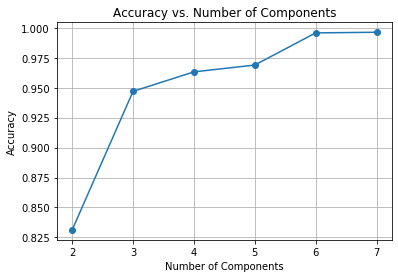

In [30]:
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Step 1: Data Preprocessing - Import data and labels

# Step 2: Data Splitting
X_train, X_test, y_train, y_test = train_test_split(normalized_spectra_wo_nan, label_mask_wo_nan, test_size=0.2, random_state=42)

# Initialize an empty list to store accuracy values
accuracy_values = []

# Step 6: Model Evaluation
for n_components in range(2, 8):
    # Step 3: PCA for Dimensionality Reduction
    pca = PCA(n_components=n_components)

    # Step 4: SVM Model Selection
    svm_model = SVC(kernel='rbf', C=1.0, gamma='scale')  # Example with an RBF kernel

    # Step 5: Create a Pipeline
    # Combine PCA and SVM into a single pipeline
    model = Pipeline([('pca', pca), ('svm', svm_model)])

    # Step 7: Model Training
    model.fit(X_train, y_train)

    # Step 6: Model Evaluation
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    # Append the accuracy to the list
    accuracy_values.append(accuracy)

# Step 8: Hyperparameter Tuning (if needed)

# Step 9: Model Deployment
# You can now use the trained model with the optimal number of components to make predictions on new data.

# Step 10: Plot the accuracy values
components_range = list(range(2, 8))
plt.plot(components_range, accuracy_values, marker='o')
plt.title('Accuracy vs. Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

## Naive Bayes

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

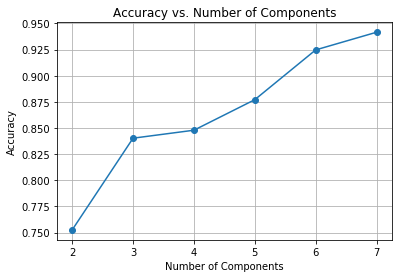

In [33]:
# Step 1: Data Preprocessing - Import data and labels

# Step 2: Data Splitting
X_train, X_test, y_train, y_test = train_test_split(normalized_spectra_wo_nan, label_mask_wo_nan, test_size=0.2, random_state=42)

# Initialize an empty list to store accuracy values
accuracy_values = []

# Step 6: Model Evaluation
for n_components in range(2, 8):
    # Step 3: PCA for Dimensionality Reduction
    pca = PCA(n_components=n_components)

    # Step 4: Naive Bayes Model Selection (Gaussian Naive Bayes)
    nb_model = GaussianNB()

    # Step 5: Create a Pipeline
    # Combine PCA and Naive Bayes into a single pipeline
    model = Pipeline([('pca', pca), ('nb', nb_model)])

    # Step 7: Model Training
    model.fit(X_train, y_train)

    # Step 6: Model Evaluation
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    # Append the accuracy to the list
    accuracy_values.append(accuracy)

# Step 8: Hyperparameter Tuning (if needed)

# Step 9: Model Deployment
# You can now use the trained model with the optimal number of components to make predictions on new data.

# Step 10: Plot the accuracy values
components_range = list(range(2, 8))
plt.plot(components_range, accuracy_values, marker='o')
plt.title('Accuracy vs. Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

## Random Forest

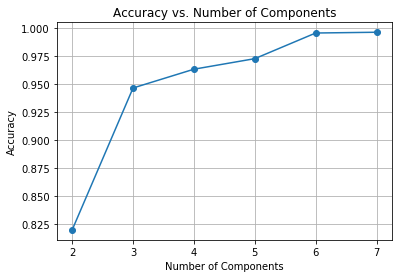

In [35]:
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Step 1: Data Preprocessing - Import data and labels

# Step 2: Data Splitting
X_train, X_test, y_train, y_test = train_test_split(normalized_spectra_wo_nan, label_mask_wo_nan, test_size=0.2, random_state=42)

# Initialize an empty list to store accuracy values
accuracy_values = []

# Step 6: Model Evaluation
for n_components in range(2, 8):
    # Step 3: PCA for Dimensionality Reduction
    pca = PCA(n_components=n_components)

    # Step 4: Random Forest Model Selection
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

    # Step 7: Model Training
    # Apply PCA and then train the Random Forest model
    X_train_pca = pca.fit_transform(X_train)
    rf_model.fit(X_train_pca, y_train)

    # Step 6: Model Evaluation
    X_test_pca = pca.transform(X_test)
    y_pred = rf_model.predict(X_test_pca)
    accuracy = accuracy_score(y_test, y_pred)
    
    # Append the accuracy to the list
    accuracy_values.append(accuracy)

# Step 8: Hyperparameter Tuning (if needed)

# Step 9: Model Deployment
# You can now use the trained model with the optimal number of components to make predictions on new data.

# Step 10: Plot the accuracy values
components_range = list(range(2, 8))
plt.plot(components_range, accuracy_values, marker='o')
plt.title('Accuracy vs. Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

## Deep Learning

In [21]:
device = torch.device("cuda")

In [18]:
from torch.utils.data import TensorDataset, DataLoader, SubsetRandomSampler

In [19]:
dataset_tensor = torch.tensor(normalized_spectra_wo_nan, dtype=torch.long)
labels_tensor = torch.tensor(label_mask_wo_nan, dtype=torch.long)

In [22]:
# Determine the sizes of your train, validation, and test sets
train_size = 0.6
val_size = 0.2
test_size = 0.2

# Define number of workers for GPU
num_workers = 6

# Step 1: Split the dataset into train and temp sets
data_train, data_temp, labels_train, labels_temp = train_test_split(dataset_tensor, labels_tensor, test_size=(1 - train_size))

# Step 2: Split the temp set into validation and test sets
data_val, data_test, labels_val, labels_test = train_test_split(data_temp, labels_temp, test_size=test_size / (test_size + val_size))

# Step 3: Create datasets and data loaders
train_dataset = TensorDataset(data_train, labels_train)
val_dataset = TensorDataset(data_val, labels_val)
test_dataset = TensorDataset(data_test, labels_test)

# Define data loaders for train, validation, and test sets
batch_size = 32  # Adjust as needed
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

In [23]:
class ModelC2(torch.nn.Module):
    def __init__(self):
        super(ModelC2, self).__init__()

        self.dense1 = torch.nn.Linear(1600, 8)
        self.dense2 = torch.nn.Linear(8, 8)
        self.dense3 = torch.nn.Linear(8, 10)
        self.softmax = torch.nn.Softmax(dim=1)

    def forward(self, x):
        x = torch.relu(self.dense1(x))
        x = torch.relu(self.dense2(x))
        x = self.softmax(self.dense3(x))
        return x

In [24]:
# Initialize your model
model = ModelC2()
# model = model.to(device)  # Moves the model to GPU

# Define your loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Number of epochs
num_epochs = 100

# Initialize lists to store metrics
train_losses = []
val_losses = []
val_accuracies = []

In [25]:
# Check if the model is on the GPU
if next(model.parameters()).is_cuda:
    print("Model is on GPU")
else:
    print("Model is on CPU")

# # Check if your tensors are on the GPU (e.g., inputs and labels)
# if inputs.is_cuda:
#     print("Inputs are on GPU")
# else:
#     print("Inputs are on CPU")

# if labels.is_cuda:
#     print("Labels are on GPU")
# else:
#     print("Labels are on CPU")

Model is on CPU


In [ ]:
for epoch in range(num_epochs):
    # Training phase
    model.train()
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU
        outputs = model(inputs.float())
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    # Validation phase
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU
            outputs = model(inputs.float())
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
    # Calculate metrics for the epoch
    train_losses.append(loss.item())
    val_losses.append(val_loss / len(val_loader))
    val_accuracy = (100 * correct / total)
    val_accuracies.append(val_accuracy)


    # Print the training and validation statistics for the epoch
    print(f"Epoch {epoch+1}/{num_epochs} - Training Loss: {loss.item():.4f} - Validation Loss: {val_loss/len(val_loader):.4f} - Validation Accuracy: {(100 * correct / total):.2f}%")

print("Training finished.")

In [ ]:
model_c2 = ModelC2()

# Load the trained model
# model_c2.load_state_dict(torch.load('model.pt'))

# Make a prediction on a new data point
new_data = torch.randn(1024)
prediction = model_c2(new_data)

# Get the class with the highest probability
predicted_class = torch.argmax(prediction)

# Print the predicted class
print(predicted_class)